In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization,Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import keras.backend as K


class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

callback = StopAtThresholdCallback(threshold=1e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 

class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)
    
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)


2023-11-14 15:17:13.448318: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 15:17:13.899483: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Cosine Prediction
## Our method / CP decomposition 
* n = 4
* 64 Neurons per Dense layer 
* Lr: 0.001
* Batch Size: 64
* Epochs: 150, Stopping when prediction better than 1e-04
* 10000 Samples -2π to 2π


2023-11-14 15:17:16.162957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 15:17:16.179568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 15:17:16.179753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 h2_layer (H2Layer)          (None, 64)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                                 
 h3_layer (H3Layer)          (None, 64)                64    

ion/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 15:17:16.566126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 15:17:16.566253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 15:17:16.566356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46191 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4d:00.0, compute capability: 8.6


Epoch 1/150


2023-11-14 15:17:18.376309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 15:17:18.377545: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fccaa168850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 15:17:18.377556: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-14 15:17:18.380642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 15:17:18.484988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-14 15:17:18.574601: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 3s 4ms/step - loss: 0.5018 - val_loss: 0.5170
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4951 - val_loss: 0.5166
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4942 - val_loss: 0.5167
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4937 - val_loss: 0.5172
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4938 - val_loss: 0.5166
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4943 - val_loss: 0.5167
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4947 - val_loss: 0.5170
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4937 - val_loss: 0.5174
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4964 - val_loss: 0.5166
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4959 - val_loss: 0.5169
E

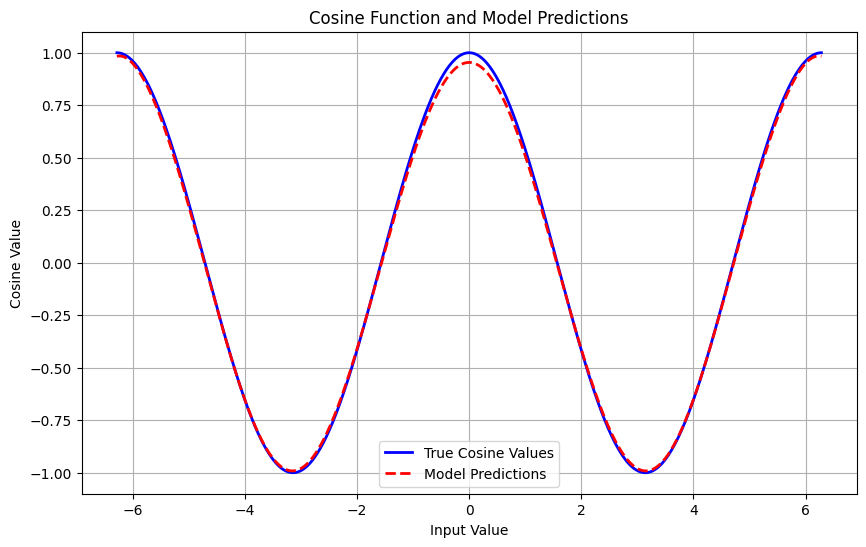

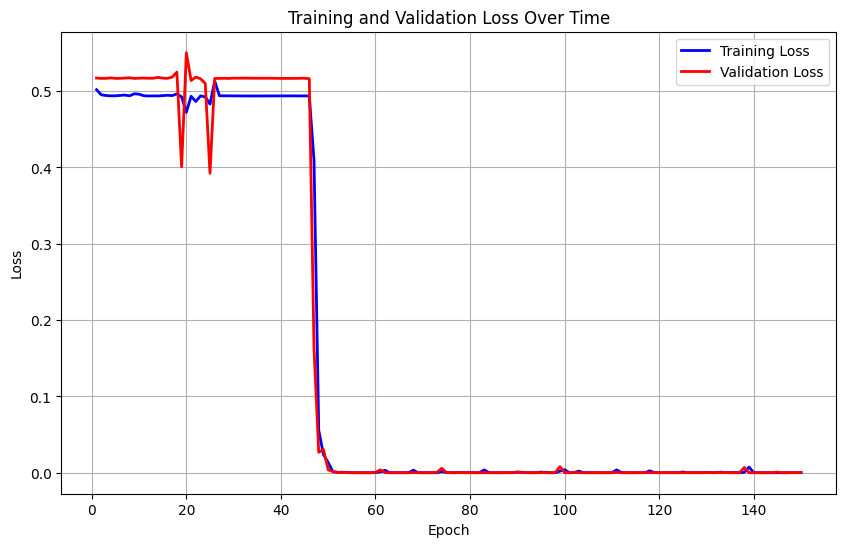

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()


# 150 EPOCHS - VAL Loss: 7.5513e-05 stopped at epoch 13

# Cosine Prediction
## Our method / Batch Normalization
* n = 4
* 64 Neurons per Dense layer 
* Lr: 0.001
* Batch Size: 64
* Epochs: 150, Stopping when prediction better than 1e-04
* 10000 Samples -2π to 2π


2023-10-31 15:09:52.488297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 h2_layer (H2Layer)          (None, 64)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 h3_layer (H3Layer)          (None, 64)                64        
                                                             

2023-10-31 15:09:52.505206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:09:52.505396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:09:52.507537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2023-10-31 15:09:54.863819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-31 15:09:54.865517: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6770f0a520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 15:09:54.865528: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-31 15:09:54.868851: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 15:09:54.975414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-31 15:09:55.059136: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 3s 5ms/step - loss: 0.2645 - val_loss: 111.3635
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 65.2481
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0676 - val_loss: 7.7267
Epoch 4/150
125/125 [==============================] - 0s 4ms/step - loss: 0.0869 - val_loss: 2.4805
Epoch 5/150
125/125 [==============================] - 0s 4ms/step - loss: 0.0624 - val_loss: 7.5572
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0360 - val_loss: 0.7272
Epoch 7/150
125/125 [==============================] - 0s 4ms/step - loss: 0.0301 - val_loss: 0.6973
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.5428
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.6698
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0296 - val_loss: 0.652

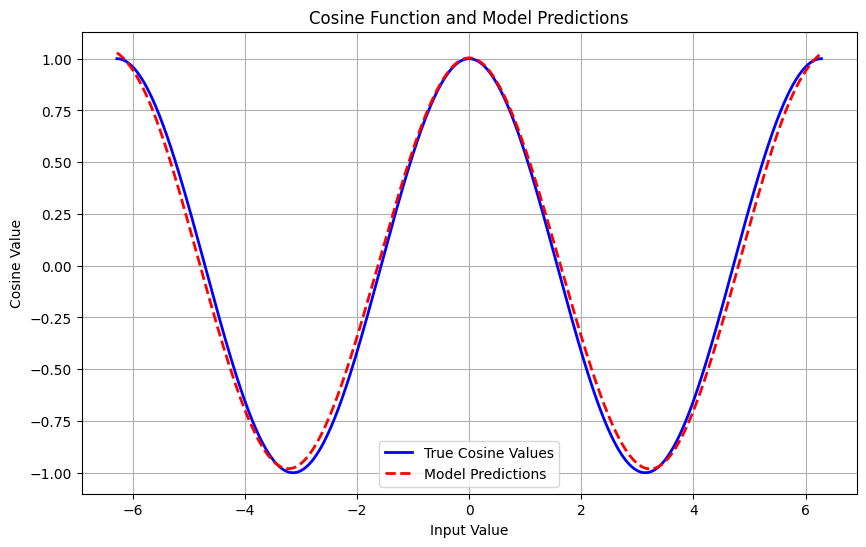

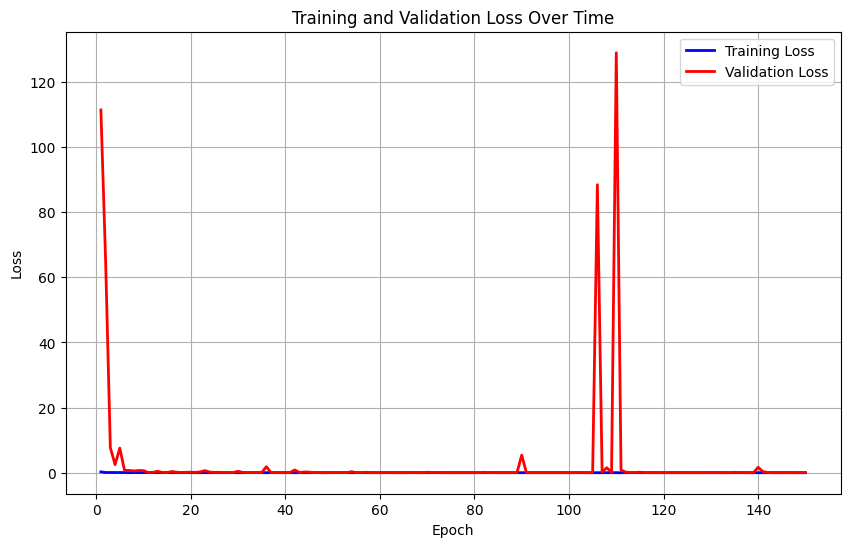

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = BatchNormalization()(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = BatchNormalization()(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = BatchNormalization()(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])


train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()


# 150 EPOCHS - VAL Loss: 0.0029 Stopped at epoch 150

# Cosine Prediction
## 4 layers Deep Network with ReLU Activation Function. 
* 64 Neurons per Dense layer 
* Lr: 0.001
* Batch Size: 64
* Epochs: 150, Stopping when prediction better than 1e-04
* 10000 Samples -2π to 2π


2023-10-31 15:20:53.128434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12673 (49.50 KB)
Trainable params: 12673 (49.50

2023-10-31 15:20:53.145212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:20:53.145399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:20:53.147442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 2s 3ms/step - loss: 0.3391 - val_loss: 0.0313
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 7.7501e-04
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 6.6068e-04 - val_loss: 0.0012
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 7.6238e-04 - val_loss: 0.0011
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 9.7161e-04 - val_loss: 2.2616e-04
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 3.0904e-04 - val_loss: 2.4792e-04
Epoch 7/150
125/125 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 8.4511e-04
Epoch 8/150
125/125 [==============================] - 0s 2ms/step - loss: 3.3362e-04 - val_loss: 1.9249e-04
Epoch 9/150
125/125 [==============================] - 0s 2ms/step - loss: 2.6489e-04 - val_loss: 5.0225e-04
Epoch 10/150
125/125 [==============================] -

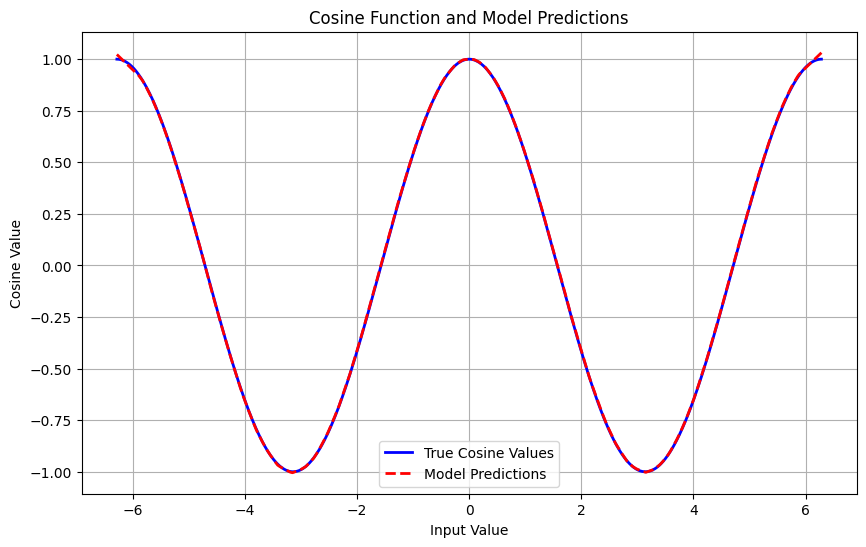

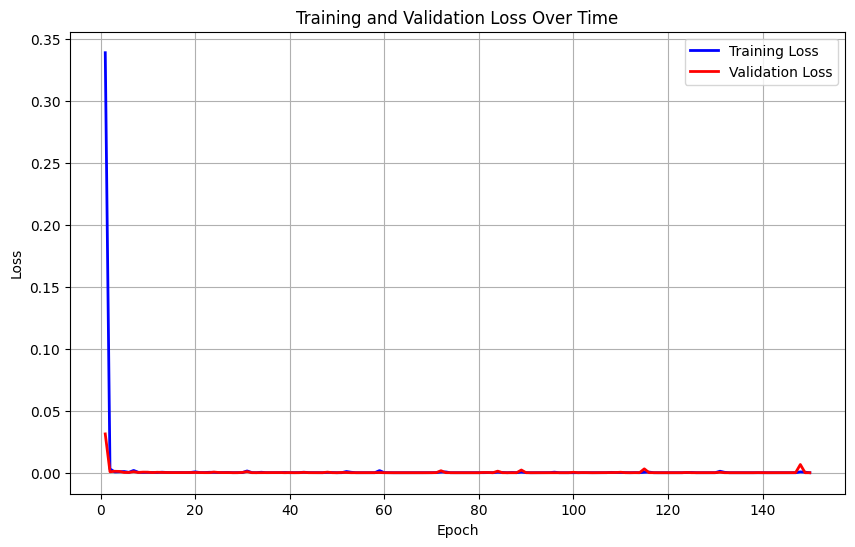

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Dense(filters, activation="relu")(x)
    x = Dense(filters, activation="relu")(x)
    x = Dense(filters, activation="relu")(x)
    x = Dense(filters, activation="relu")(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])


train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")


import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()


# 150 EPOCHS - VAL Loss: 0.0062 stopped at epoch 150

# Cosine Prediction
## 4 layers Deep Network Sigmoid Activation Function
* 64 Neurons per Dense layer 
* Lr: 0.001
* Batch Size: 64
* Epochs: 150, Stopping when prediction better than 1e-04
* 10000 Samples -2π to 2π


2023-10-31 15:25:35.400358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12673 (49.50 KB)
Trainable params: 12673 (49.50

2023-10-31 15:25:35.417646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:25:35.417835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:25:35.419963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 2s 3ms/step - loss: 0.4983 - val_loss: 0.5183
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4966 - val_loss: 0.5167
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4958 - val_loss: 0.5170
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4951 - val_loss: 0.5165
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4970 - val_loss: 0.5197
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4972 - val_loss: 0.5169
Epoch 7/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4946 - val_loss: 0.5155
Epoch 8/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4927 - val_loss: 0.5127
Epoch 9/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4887 - val_loss: 0.4999
Epoch 10/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4526 - val_loss: 0.4204
E

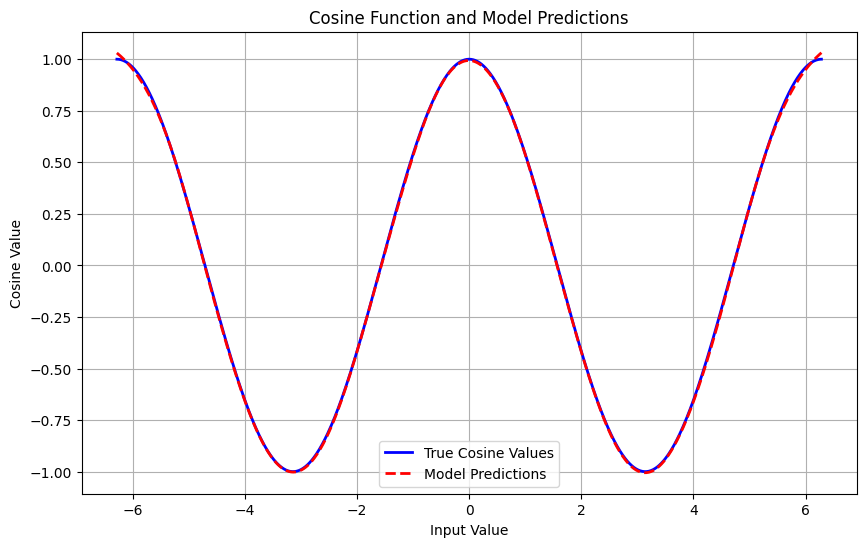

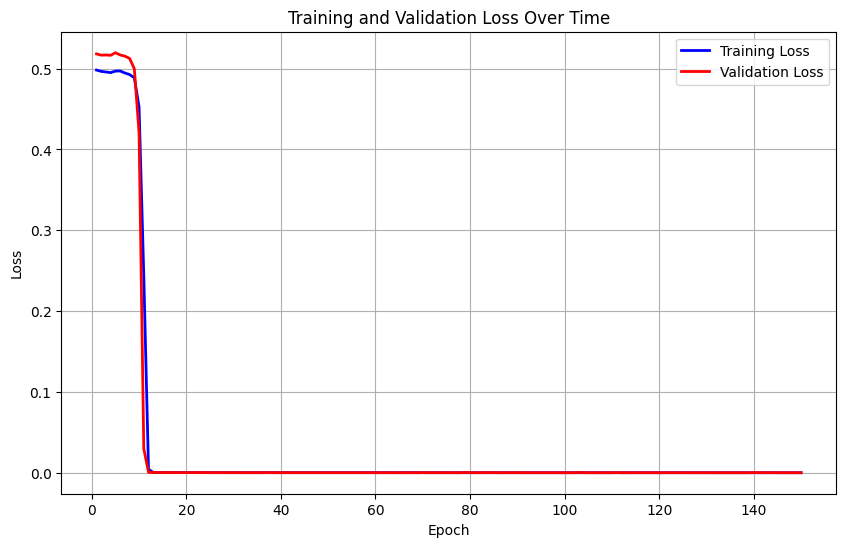

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Dense(filters, activation="sigmoid")(x)
    x = Dense(filters, activation="sigmoid")(x)
    x = Dense(filters, activation="sigmoid")(x)
    x = Dense(filters, activation="sigmoid")(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# 150 EPOCHS - VAL Loss: 0.0023 stopped at epoch 150

# Cosine Prediction
## 4 layers Deep Network,  Tanh Activation Function.
* n = 4
* 64 Neurons per Dense layer 
* Lr: 0.001
* Batch Size: 64
* Epochs: 150, Stopping when prediction better than 1e-04
* 10000 Samples -2π to 2π


2023-10-31 15:28:42.767983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12673 (49.50 KB)
Trainable params: 12673 (49.50

2023-10-31 15:28:42.785344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:28:42.785524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:28:42.787576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 2s 3ms/step - loss: 0.4089 - val_loss: 0.2644
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 0.0936 - val_loss: 0.0024
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 6.5780e-04
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 5.8372e-04 - val_loss: 3.6599e-04
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 3.6975e-04 - val_loss: 2.6668e-04
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 3.6249e-04 - val_loss: 1.9001e-04
Epoch 7/150
125/125 [==============================] - 0s 2ms/step - loss: 2.2329e-04 - val_loss: 2.7301e-04
Epoch 8/150
125/125 [==============================] - 0s 2ms/step - loss: 2.3411e-04 - val_loss: 3.0634e-04
Epoch 9/150
125/125 [==============================] - 0s 2ms/step - loss: 2.3971e-04 - val_loss: 2.2473e-04
Epoch 10/150
125/125 [=============================

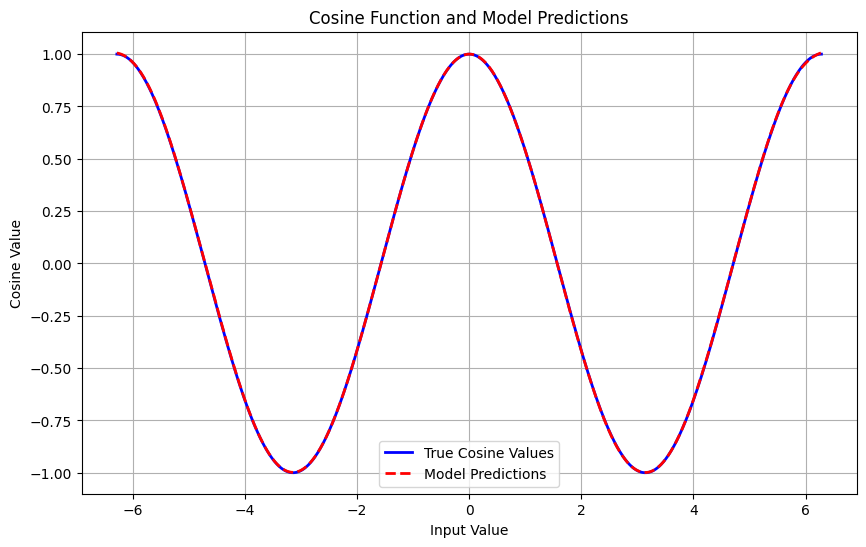

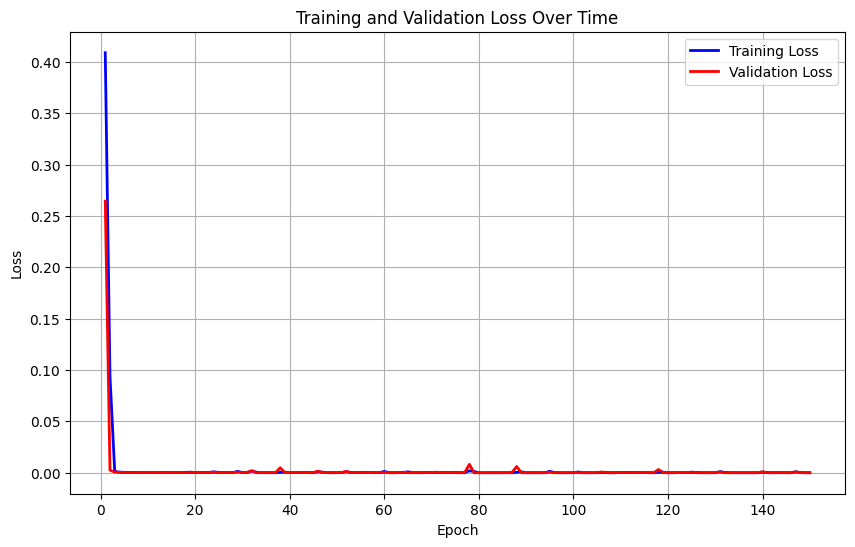

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Dense(filters, activation="tanh")(x)
    x = Dense(filters, activation="tanh")(x)
    x = Dense(filters, activation="tanh")(x)
    x = Dense(filters, activation="tanh")(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")


import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# 150 EPOCHS - VAL Loss: 0.0028 stopped at epoch 150

# Cosine Test Controlled Randomness

2023-10-19 14:30:26.924903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 h2_layer (H2Layer)          (None, 64)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                                 
 h3_layer (H3Layer)          (None, 64)                64    

2023-10-19 14:30:26.942249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 14:30:26.942431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 14:30:26.944517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2023-10-19 14:30:29.127562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-19 14:30:29.128870: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbbcba4bc60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-19 14:30:29.128880: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-19 14:30:29.131955: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-19 14:30:29.236303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-19 14:30:29.325142: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 3s 4ms/step - loss: 0.3273 - val_loss: 0.0498
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0240 - val_loss: 0.0029
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 9.7494e-04 - val_loss: 8.0075e-04
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 4.0298e-05
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 4.9641e-05 - val_loss: 9.1302e-05
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 5.5807e-05 - val_loss: 5.6926e-05
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 2.9094e-04 - val_loss: 2.5572e-06
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 2.3943e-06 - val_loss: 2.0475e-06
Epoch 10/150
125/125 [==============================] - 0s 

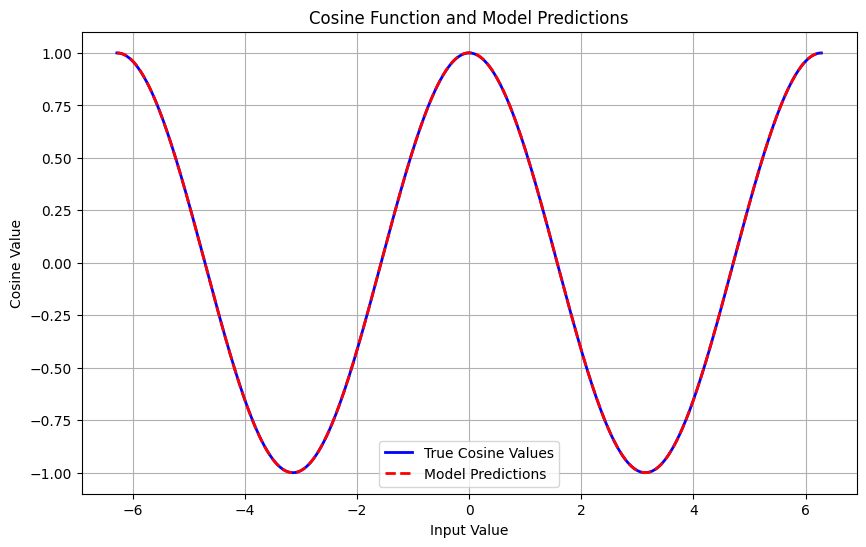

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)

    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = h2(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback,print_shape_callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



# Cosine pred Relu + Tensor Decomposition

2023-10-31 14:53:13.608658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                                 
 activation_1 (Activation)   (None, 64)                0     

2023-10-31 14:53:13.625425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 14:53:13.625611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 14:53:13.627567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 4ms/step - loss: 0.2852 - val_loss: 0.0101
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 8.8929e-04 - val_loss: 7.0031e-04
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 5.0396e-04 - val_loss: 4.5804e-04
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 2.8674e-04 - val_loss: 3.0118e-04
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 2.0

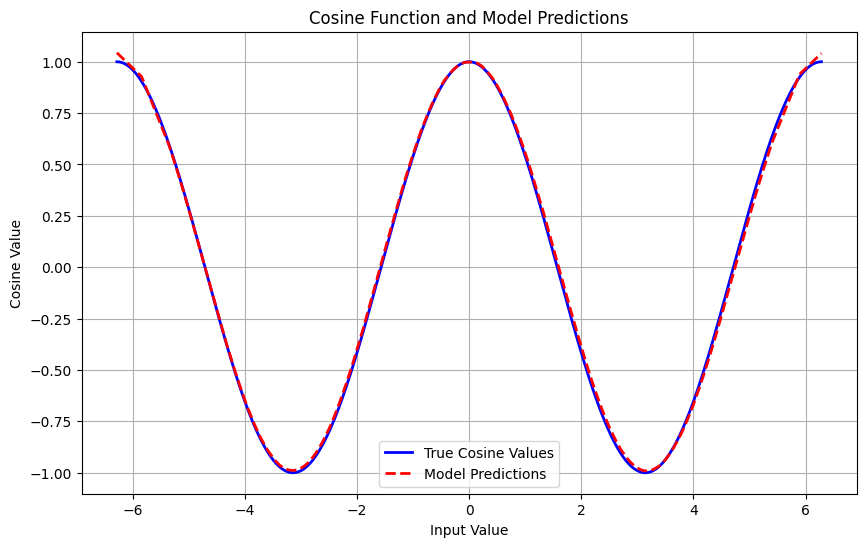

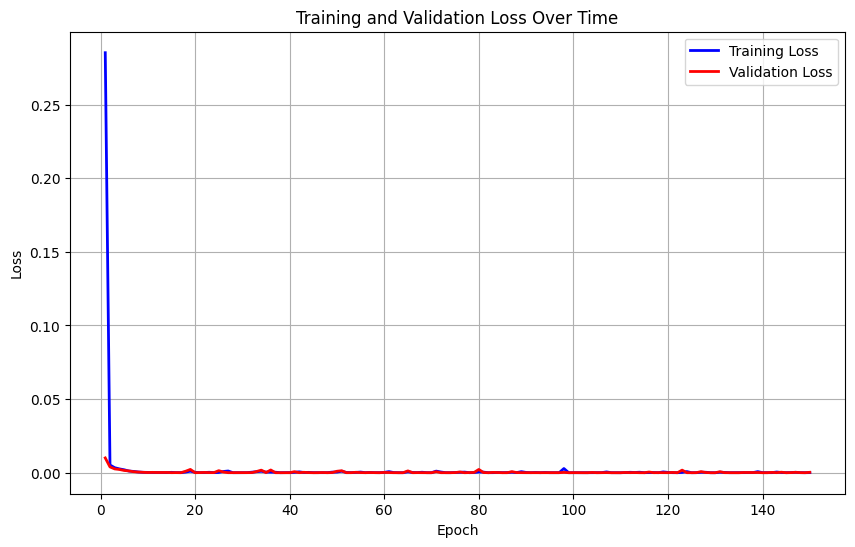

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Dense(filters)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])


train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# Cosine pred Sigmoid + Tensor Decomposition

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                                 
 activation_1 (Activation)   (None, 64)                0     

2023-10-31 15:01:56.251733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:01:56.273757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:01:56.273944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 3ms/step - loss: 0.4941 - val_loss: 0.5166
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4937 - val_loss: 0.5168
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.5169
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.5167
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5169
Epoch 7/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4935 - val_loss: 0.5166
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5169
Epoch 9/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4937 - val_loss: 0.5166
E

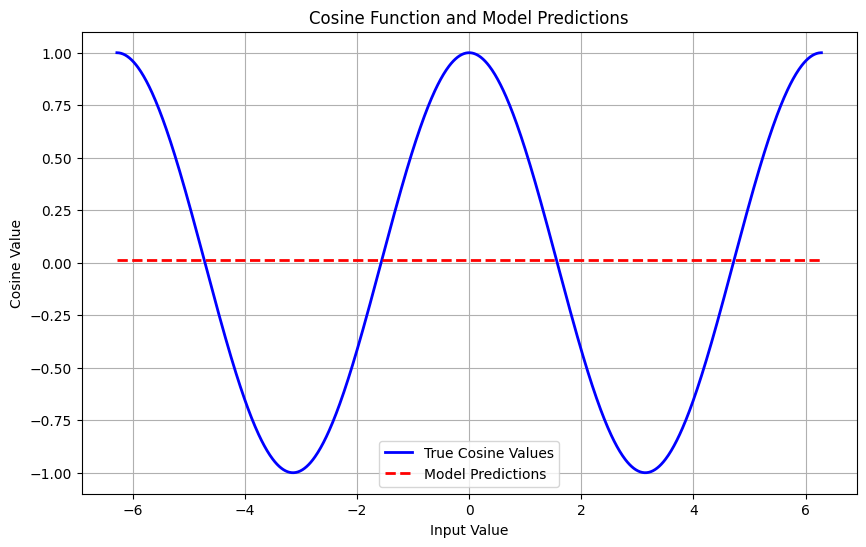

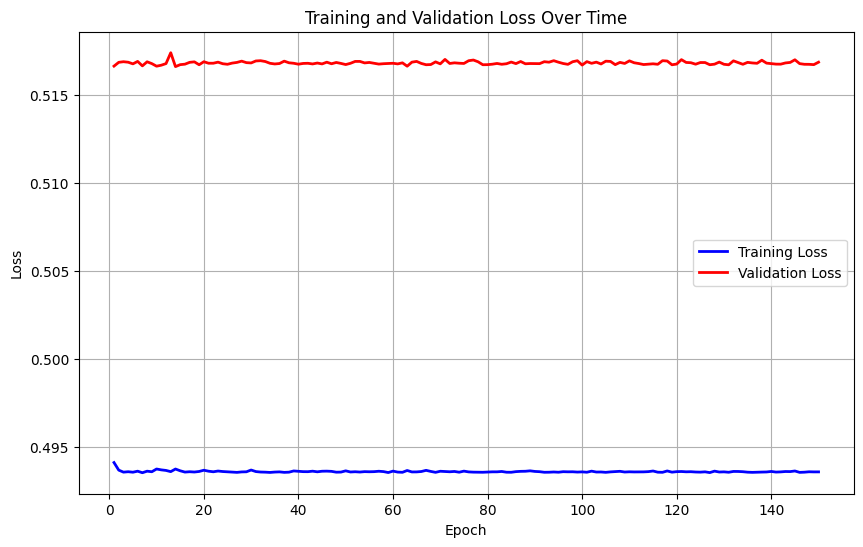

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Dense(filters)(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])


train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()


2023-10-31 15:04:27.494803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                                 
 activation_1 (Activation)   (None, 64)                0     

2023-10-31 15:04:27.511522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:04:27.511706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:04:27.513636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 3ms/step - loss: 0.4936 - val_loss: 0.5167
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.5168
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5167
Epoch 7/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4936 - val_loss: 0.5167
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 9/150
125/125 [==============================] - 0s 2ms/step - loss: 0.4936 - val_loss: 0.5169
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
E

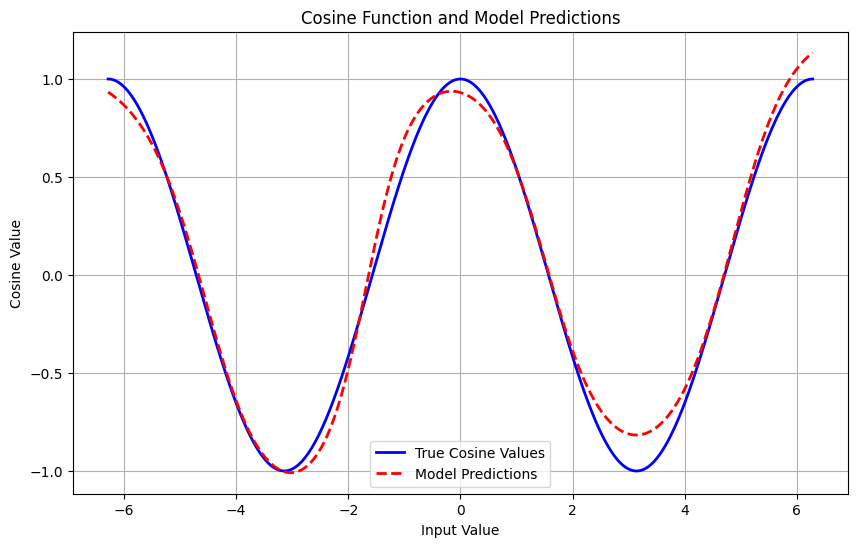

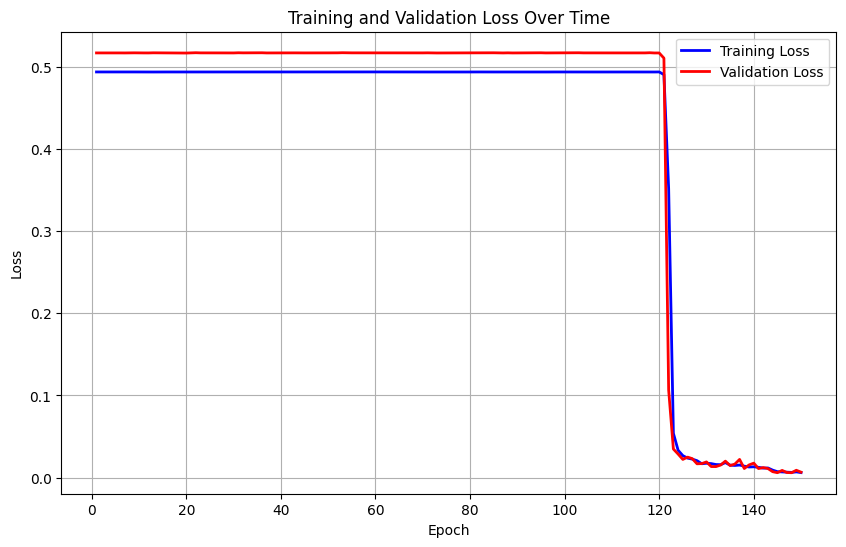

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Dense(filters)(x)
    x = Activation("tanh")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("tanh")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("tanh")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

## Cosine Pred using Relu + Tensor Decomposition + Weight 

2023-11-14 12:32:38.163939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:32:38.181386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:32:38.181576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 relu__with__weight (Relu_W  (None, 64)                64        
 ith_Weight)                                                     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                             

2023-11-14 12:32:38.184830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:32:38.185091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:32:38.185313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 3ms/step - loss: 0.4936 - val_loss: 0.5167
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5169
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1371 - val_loss: 0.0034
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 7.5205e-04
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 8.8214e-04 - val_loss: 6.3892e-04
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 5.3465e-04 - val_loss: 4.0623e-04
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 3.8086e

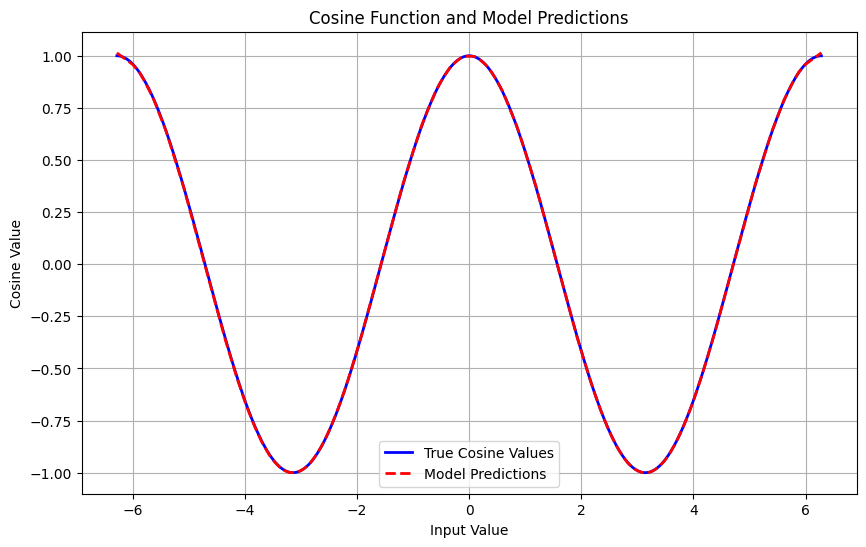

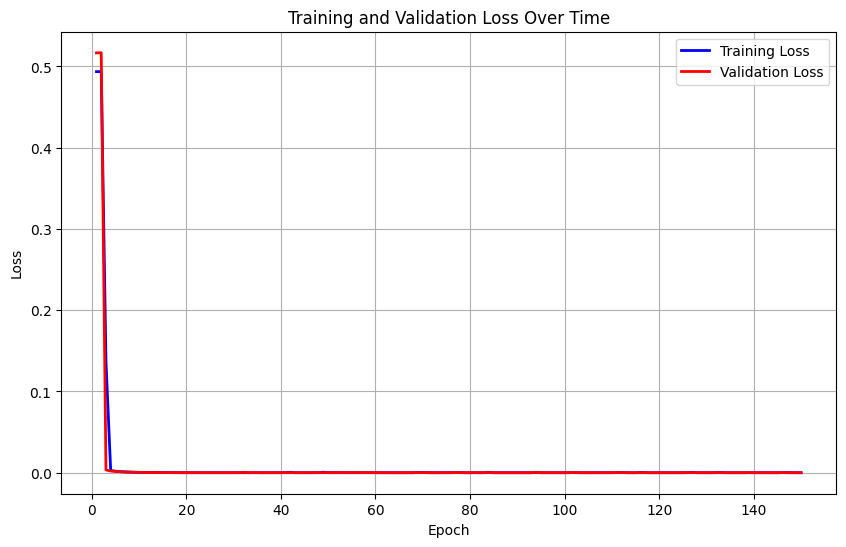

In [5]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    modRelu = Relu_With_Weight()

    x = Dense(filters)(x)
    # x = Activation("relu")(x)
    x = modRelu(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

## Cosine Pred using Sigmoid + Tensor Decomposition + Weight 

2023-11-14 12:47:18.611260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 relu__with__weight (Relu_W  (None, 64)                64        
 ith_Weight)                                                     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                             

2023-11-14 12:47:18.628545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:47:18.628734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:47:18.630847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 4ms/step - loss: 0.4939 - val_loss: 0.5167
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4940 - val_loss: 0.5169
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4941 - val_loss: 0.5166
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5183
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4939 - val_loss: 0.5167
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5167
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5169
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5169
E

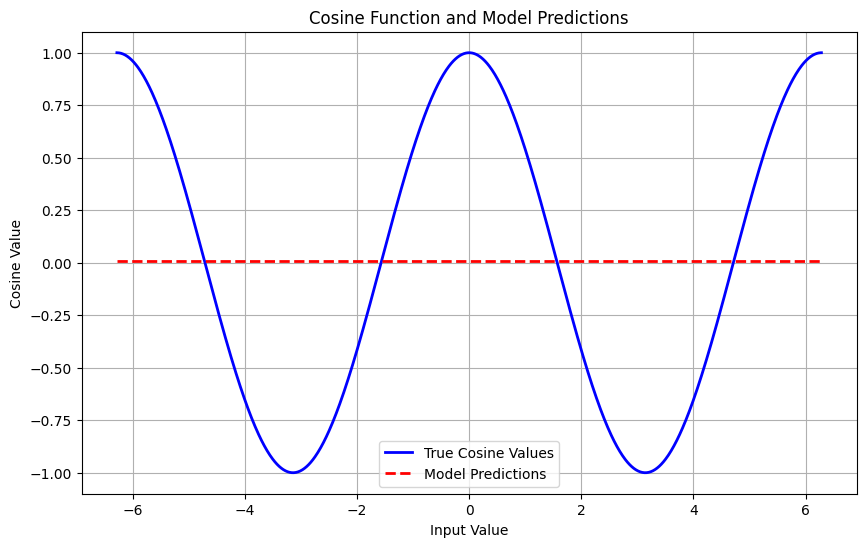

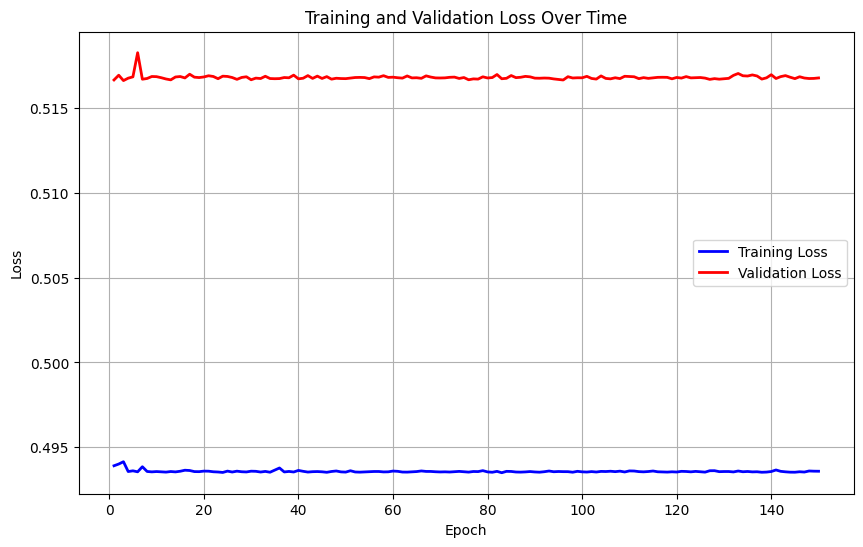

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    modRelu = Relu_With_Weight()

    x = Dense(filters)(x)
    # x = Activation("relu")(x)
    x = modRelu(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("sigmoid")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

## Cosine Pred using Tanh + Tensor Decomposition + Weight 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 relu__with__weight (Relu_W  (None, 64)                64        
 ith_Weight)                                                     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                             

2023-11-14 12:58:42.591355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:58:42.608380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:58:42.608566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 4ms/step - loss: 0.4936 - val_loss: 0.5167
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.5168
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5167
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5169
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4935 - val_loss: 0.5168
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5168
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5171
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5169
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4936 - val_loss: 0.5169
E

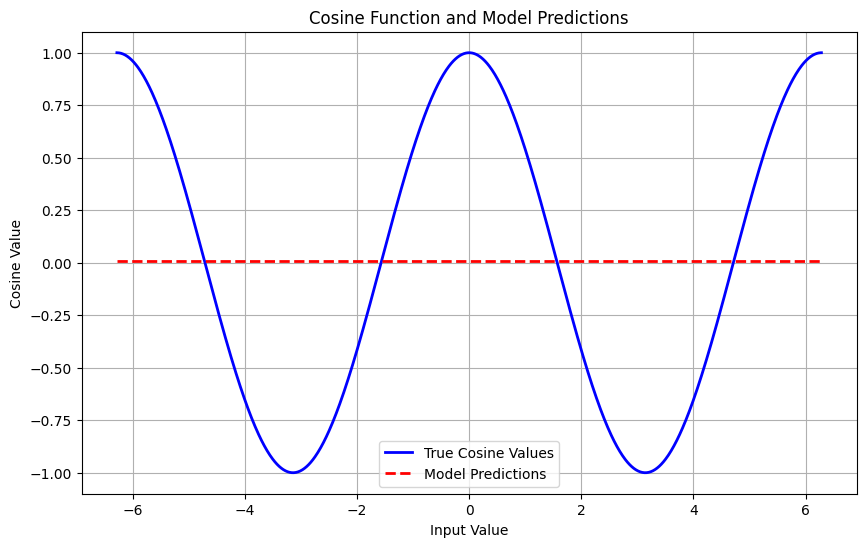

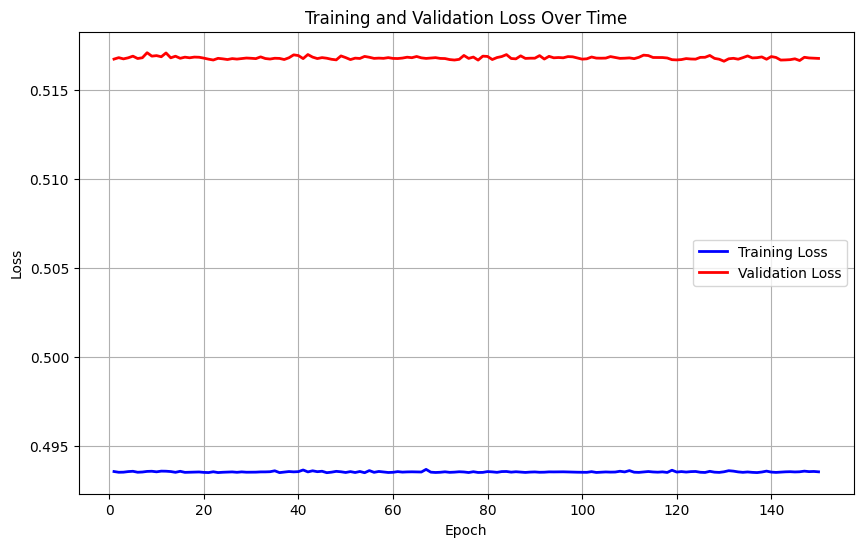

In [2]:
## Cosine Pred using Sigmoid + Tensor Decomposition + Weight 
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    modRelu = Relu_With_Weight()

    x = Dense(filters)(x)
    # x = Activation("relu")(x)
    x = modRelu(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("tanh")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Activation("tanh")(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()